In [1]:
import importlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import decision_learning.data.shortest_path_grid
importlib.reload(decision_learning.data.shortest_path_grid)
from decision_learning.data.shortest_path_grid import piecewise_linear

### Testing Piecewise Linear Function

2024-10-30 08:49:39,155 - decision_learning.data.shortest_path_grid - DEBUG - chg_pt: 0.55
2024-10-30 08:49:39,158 - decision_learning.data.shortest_path_grid - DEBUG - chg_pt: 0.0


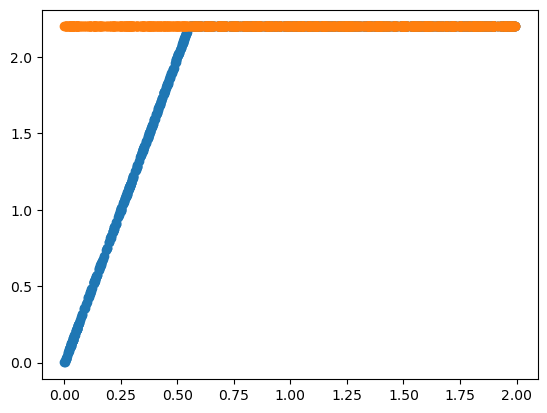

In [2]:
rnd = np.random.RandomState(1)
x = rnd.uniform(low=0, 
            high=2, 
            size=1000)
y_red = piecewise_linear(x,
                    slope0=4, 
                    int0=0,
                    slope1=0, 
                    int1=2.2)
y_blue = piecewise_linear(x,
                    slope0=0, 
                    int0=2.2,
                    slope1=0, 
                    int1=2.2)
plt.scatter(x, y_red)
plt.scatter(x, y_blue)

In [3]:
# Assume list1 and list2 are your lists of arrays
list1 = np.array([1, 2, 3]) 
list2 = np.array([4, 5, 6])

# Concatenate the lists
combined = np.concatenate((list1,list2))

# # Create an array of all possible indices
# all_indices = np.arange(max(combined) + 1)

# # Find the indices not in the combined list
# not_in_combined = np.setdiff1d(all_indices, combined)

# Generate Data

In [4]:
importlib.reload(decision_learning.data.shortest_path_grid)
from decision_learning.data.shortest_path_grid import add_noise, genDataPlant, shortest_path_synthetic_sym_no_noise, shortest_path_synthetic_plant_path

In [5]:
indices_arr = torch.randperm(100000)
indices_arr_test = torch.randperm(100000)

sim = 0
n_arr = [200, 400, 800, 1600]
ep_arr = ['unif', 'normal']
trials = 100

exp_arr = []
for n in n_arr:
    for ep in ep_arr:
        for t in range(trials):
            exp_arr.append([n, ep, t])

exp = exp_arr[sim]
ep_type = exp[1]
trial = exp[2]

# generate data
grid = (5, 5)  # grid size
num_data = exp[0]  # number of training data
num_feat = 5  # size of feature
deg = 6  # polynomial degree
e = .4  # noise width



In [6]:
importlib.reload(decision_learning.data.shortest_path_grid)
from decision_learning.data.shortest_path_grid import add_noise, genData, genDataPlant, shortest_path_synthetic_sym_no_noise, shortest_path_synthetic_plant_path

In [7]:
planted_good_pwl_params = {'slope0':0, 
                    'int0':2,
                    'slope1':0, 
                    'int1':2}
planted_bad_pwl_params = {'slope0':4, 
                    'int0':0,
                    'slope1':0, 
                    'int1':2.2}

In [8]:
data = shortest_path_synthetic_sym_no_noise(num_data=num_data+200,
        num_features=num_feat, 
        grid=grid, 
        deg=deg, 
        seed=indices_arr[trial])


data_plant = shortest_path_synthetic_plant_path(planted_good_pwl_params=planted_good_pwl_params,
                                   planted_bad_pwl_params=planted_bad_pwl_params,
                                   seed=indices_arr[trial],
                                   **data)
data_noise = add_noise(c=data_plant['c_plant'],
          noise_type=ep_type,
          noise_width=e,
          seed=indices_arr[trial])

2024-10-30 08:49:40,945 - decision_learning.data.shortest_path_grid - DEBUG - good_bad_edges: [ 1  4  9 16 24 31 36 39  0  3  8 15 23 30 35 38], remain_edges: [ 2  5  6  7 10 11 12 13 14 17 18 19 20 21 22 25 26 27 28 29 32 33 34 37]
2024-10-30 08:49:40,946 - decision_learning.data.shortest_path_grid - DEBUG - chg_pt: 0.0
2024-10-30 08:49:40,947 - decision_learning.data.shortest_path_grid - DEBUG - chg_pt: 0.55


One genData Function

In [9]:
final_data = genData(num_data=num_data+200,
        num_features=num_feat, 
        grid=grid, 
        deg=deg, 
        noise_type=ep_type,
        noise_width=e,
        seed=indices_arr[trial],     
        plant_edges=False,
        planted_good_pwl_params=planted_good_pwl_params,
        planted_bad_pwl_params=planted_bad_pwl_params)

In [10]:
final_data['cost'].shape

(400, 40)

In [11]:
import decision_learning.modeling.models
importlib.reload(decision_learning.modeling.models)
from decision_learning.modeling.models import LinearRegression

In [12]:
lr_mod = LinearRegression(input_dim=final_data['feat'].shape[1],
                 output_dim=final_data['cost'].shape[1])

In [13]:
c_pred = lr_mod(torch.tensor(final_data['feat'], dtype=torch.float))

In [14]:
c_pred

tensor([[ 4.5614e-01, -8.1670e-04, -1.6145e-01,  ..., -5.1179e-01,
          1.1820e-01, -4.9448e-01],
        [-1.0494e-01,  7.3423e-01,  3.3650e-01,  ...,  5.0490e-01,
          9.1026e-01,  7.2220e-01],
        [ 6.7327e-01,  6.6797e-01, -1.9701e-01,  ..., -1.4250e+00,
         -3.4055e-01, -5.9946e-02],
        ...,
        [ 1.0182e+00, -1.0435e+00,  4.9286e-01,  ..., -1.3806e+00,
         -5.8206e-01, -1.1913e+00],
        [ 8.4221e-01, -1.9684e-01, -3.5824e-01,  ..., -5.4777e-01,
         -4.4760e-01, -9.9908e-01],
        [ 1.3897e+00,  3.9766e-01,  3.0643e-01,  ..., -4.8733e-01,
         -1.0998e+00, -2.9522e-01]], grad_fn=<AddmmBackward0>)

# Initial Solution using optimization Solver

In [15]:
from pyepo.model.opt import optModel
from pyepo import EPO

def shortest_path_solver(costs, size, sens = 1e-4):
    # Forward Pass
    starting_ind = 0
    starting_ind_c = 0
    samples = costs.shape[0]
    V_arr = torch.zeros(samples, size ** 2)
    for i in range(0, 2 * (size - 1)):
        num_nodes = min(i + 1, 9 - i)
        num_nodes_next = min(i + 2, 9 - i - 1)
        num_arcs = 2 * (max(num_nodes, num_nodes_next) - 1)
        V_1 = V_arr[:, starting_ind:starting_ind + num_nodes]
        layer_costs = costs[:, starting_ind_c:starting_ind_c + num_arcs]
        l_costs = layer_costs[:, 0::2]
        r_costs = layer_costs[:, 1::2]
        next_V_val_l = torch.ones(samples, num_nodes_next) * float('inf')
        next_V_val_r = torch.ones(samples, num_nodes_next) * float('inf')
        if num_nodes_next > num_nodes:
            next_V_val_l[:, :num_nodes_next - 1] = V_1 + l_costs
            next_V_val_r[:, 1:num_nodes_next] = V_1 + r_costs
        else:
            next_V_val_l = V_1[:, :num_nodes_next] + l_costs
            next_V_val_r = V_1[:, 1:num_nodes_next + 1] + r_costs
        next_V_val = torch.minimum(next_V_val_l, next_V_val_r)
        V_arr[:, starting_ind + num_nodes:starting_ind + num_nodes + num_nodes_next] = next_V_val

        starting_ind += num_nodes
        starting_ind_c += num_arcs

    # Backward Pass
    starting_ind = size ** 2
    starting_ind_c = costs.shape[1]
    prev_act = torch.ones(samples, 1)
    sol = torch.zeros(costs.shape)
    for i in range(2 * (size - 1), 0, -1):
        num_nodes = min(i + 1, 9 - i)
        num_nodes_next = min(i, 9 - i + 1)
        V_1 = V_arr[:, starting_ind - num_nodes:starting_ind]
        V_2 = V_arr[:, starting_ind - num_nodes - num_nodes_next:starting_ind - num_nodes]

        num_arcs = 2 * (max(num_nodes, num_nodes_next) - 1)
        layer_costs = costs[:, starting_ind_c - num_arcs: starting_ind_c]

        if num_nodes < num_nodes_next:
            l_cs_res = ((V_2[:, :num_nodes_next - 1] - V_1 + layer_costs[:, ::2]) < sens) * prev_act
            r_cs_res = ((V_2[:, 1:num_nodes_next] - V_1 + layer_costs[:, 1::2]) < sens) * prev_act
            prev_act = torch.zeros(V_2.shape)
            prev_act[:, :num_nodes_next - 1] += l_cs_res
            prev_act[:, 1:num_nodes_next] += r_cs_res
        else:
            l_cs_res = ((V_2 - V_1[:, :num_nodes - 1] + layer_costs[:, ::2]) < sens) * prev_act[:, :num_nodes - 1]
            r_cs_res = ((V_2 - V_1[:, 1:num_nodes] + layer_costs[:, 1::2]) < sens) * prev_act[:, 1:num_nodes]
            prev_act = torch.zeros(V_2.shape)
            prev_act += l_cs_res
            prev_act += r_cs_res
        cs = torch.zeros(layer_costs.shape)
        cs[:, ::2] = l_cs_res
        cs[:, 1::2] = r_cs_res
        sol[:, starting_ind_c - num_arcs: starting_ind_c] = cs

        starting_ind = starting_ind - num_nodes
        starting_ind_c = starting_ind_c - num_arcs
    # Dimension (samples, num edges)
    obj = torch.sum(sol * costs, axis=1)
    # Dimension (samples, 1)
    return sol, obj.reshape(-1,1)

# optimization model
class optGenModel(optModel):
    """
    This is an abstract class for Pyomo-based optimization model

    Attributes:
        _model (PyOmo model): Pyomo model
        solver (str): optimization solver in the background
    """

    def __init__(self):
        """
        Args:
            solver (str): optimization solver in the background
        """
        super().__init__()
        # init obj
        if self._model.modelSense == EPO.MINIMIZE:
            self.modelSense = EPO.MINIMIZE
        if self._model.modelSense == EPO.MAXIMIZE:
            self.modelSense = EPO.MAXIMIZE

    def __repr__(self):
        return "optGenModel " + self.__class__.__name__

    def setObj(self, c):
        """
        A method to set objective function

        Args:
            c (np.ndarray / list): cost of objective function
        """
        self._model.costvec = c

    def copy(self):
        """
        A method to copy model

        Returns:
            optModel: new copied model
        """
        new_model = copy(self)
        return new_model

    def addConstr(self):
        new_model = self.copy()
        # add constraint
        return new_model

class modelclass():
    def __init__(self, size):
        self.size = size
        self.costvec = None
        self.modelSense = EPO.MINIMIZE
        self.x = np.ones(2 * size * (size - 1))
class shortestPathModel(optGenModel):

    def __init__(self):
        self.grid = (5,5)
        super().__init__()

    def _getModel(self):
        """
        A method to build Gurobi model

        Returns:
            tuple: optimization model and variables
        """
        m = modelclass(self.grid[0])
        x = m.x
        # sense
        m.modelSense = EPO.MINIMIZE
        return m, x

    def solve(self):
        sol, obj = shortest_path_solver(self._model.costvec.reshape(-1,len(self.x)), self._model.size)
        return sol, obj

Auto-Sklearn cannot be imported.


checking functionality of just `shortest_path_solver` vs `shortestPathModel`

In [16]:
optmodel = shortestPathModel()
optmodel.setObj(c_pred)
ptb_sols, ptb_obj = optmodel.solve()
sol, obj = shortest_path_solver(costs=c_pred, size=5)

torch.all(ptb_sols == sol).item(), torch.all(ptb_obj == obj).item()

(True, True)

# Create Dataset Object

In [52]:
from torch.utils.data import DataLoader
from tqdm import tqdm

import decision_learning.modeling.loss
importlib.reload(decision_learning.modeling.loss)
from decision_learning.modeling.loss import SPODataset, SPOPlus

In [18]:
# get initial 
final_data = genData(num_data=num_data+200,
        num_features=num_feat, 
        grid=grid, 
        deg=deg, 
        noise_type=ep_type,
        noise_width=e,
        seed=indices_arr[trial],     
        plant_edges=False,
        planted_good_pwl_params=planted_good_pwl_params,
        planted_bad_pwl_params=planted_bad_pwl_params)

sol, obj = shortest_path_solver(costs=final_data['cost'], size=5)

dataset = SPODataset(X=final_data['feat'],
           true_cost=final_data['cost'],
           true_sol=sol,
           true_obj=obj)
dataloader = DataLoader(dataset, 
                        batch_size=len(dataset), 
                        shuffle=True,
                       collate_fn=dataset.collate_fn)

/home1/yongpeng/decision-focused-learning/src/decision_learning/modeling/loss.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.true_sol = torch.tensor(true_sol, dtype=torch.float32) #if not isinstance(true_sol, torch.Tensor) else true_sol
/home1/yongpeng/decision-focused-learning/src/decision_learning/modeling/loss.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.true_obj = torch.tensor(true_obj, dtype=torch.float32) #if not isinstance(true_obj, torch.Tensor) else true_obj


Iterate over dataloader example

In [19]:
# Iterate over batches with tqdm progress bar
for batch_idx, batch in enumerate(tqdm(dataloader)):
    # Training/evaluation code here
    # For example, passing inputs to a model
    print(f"Batch {batch_idx}, batch keys {batch.keys()}")

100%|██████████| 1/1 [00:00<00:00, 128.51it/s]

Batch 0, batch keys dict_keys(['X', 'true_cost', 'true_sol', 'true_obj'])


# Instantiate Loss Function

## Verify Loss is Same

One training loop example

In [20]:
import inspect

def filter_kwargs(func, kwargs):
    signature = inspect.signature(func)
    valid_args = {key: value for key, value in kwargs.items() if key in signature.parameters}
    return valid_args

In [44]:
from functools import partial

lr_mod = LinearRegression(input_dim=final_data['feat'].shape[1],
                 output_dim=final_data['cost'].shape[1])
# set adam optimizer
optimizer = torch.optim.Adam(lr_mod.parameters(), lr=0.1)

Double Check Loss Function is Implemented correctly

In [45]:
cp = lr_mod(batch['X'])

Original Function

In [46]:
from decision_learning.modeling.loss import SPOPlus2_O
optmodel = shortestPathModel()
orig_loss_fn = SPOPlus2_O(optmodel=optmodel)
orig_loss = orig_loss_fn(pred_cost=cp, 
                         true_cost=batch['true_cost'], 
                         true_sol=batch['true_sol'], 
                         true_obj=batch['true_obj'])

Num of cores: 1


In [53]:
loss_fn = SPOPlus(optmodel=partial(shortest_path_solver,size=5))

new_batch = filter_kwargs(loss_fn.forward, batch)
loss2 = loss_fn(pred_cost=cp, **new_batch)

Check Original Implementation and New have same loss

In [54]:
print(orig_loss, loss2)
orig_loss == loss2

(tensor(12.0687, grad_fn=<MeanBackward0>),
 tensor(12.0687, grad_fn=<MeanBackward0>))

Check Original and New have same gradients

# Train Loop
1. Get current batch (requires a dataset object and dataloader)
2. Get Predictions
3. Get necessary components for loss function like current predicted cost solutions
4. Calculate loss function and back propogate

In [68]:
lr_mod_o = LinearRegression(input_dim=final_data['feat'].shape[1],
                 output_dim=final_data['cost'].shape[1])

New Function

In [70]:
from functools import partial
import copy

# Assuming `model` is the original model you want to copy
lr_mod = copy.deepcopy(lr_mod_o)

# set adam optimizer
optimizer = torch.optim.Adam(lr_mod.parameters(), lr=0.1)

# loss functions
loss_fn = SPOPlus(optmodel=partial(shortest_path_solver,size=5))

In [71]:
num_epochs = 10
use_gpu = False

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, batch in enumerate(tqdm(dataloader)):
            
        if use_gpu == True:
            for k in batch.keys():
                batch[k] = batch[k].cuda()
        
        # forward pass - prediction
        cp = lr_mod(batch['X'])
        # optimization get solutions with current predicted costs
        #sol, obj = shortest_path_solver(costs=cp, size=5)

        # add predicted components to batch
        #batch['pred_cost'] = cp
        # batch['opt_prob_sol'] = sol
        # batch['opt_prob_obj'] = obj
        
        # Get the function's signature
        batch = filter_kwargs(loss_fn.forward, batch)

        # loss
        #loss = loss_fn(cp.., **batch, pred_cost = pred_cost,...)
        loss = loss_fn(cp, **batch)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

        # TODO: - add in regret calc for validation calc
    
    print(np.mean(epoch_loss))

100%|██████████| 1/1 [00:00<00:00, 72.62it/s]


9.763208389282227


100%|██████████| 1/1 [00:00<00:00, 70.74it/s]


5.725973129272461


100%|██████████| 1/1 [00:00<00:00, 80.34it/s]


3.5588157176971436


100%|██████████| 1/1 [00:00<00:00, 80.70it/s]


2.555410623550415


100%|██████████| 1/1 [00:00<00:00, 80.31it/s]


2.0469818115234375


100%|██████████| 1/1 [00:00<00:00, 78.33it/s]


1.9466477632522583


100%|██████████| 1/1 [00:00<00:00, 80.01it/s]


1.9816168546676636


100%|██████████| 1/1 [00:00<00:00, 84.16it/s]


1.952664852142334


100%|██████████| 1/1 [00:00<00:00, 83.34it/s]


1.866245985031128


100%|██████████| 1/1 [00:00<00:00, 83.29it/s]

1.7920613288879395


orig loss function

In [72]:
from functools import partial

lr_mod = copy.deepcopy(lr_mod_o)
# set adam optimizer
optimizer = torch.optim.Adam(lr_mod.parameters(), lr=0.1)

# loss functions
optmodel = shortestPathModel()
orig_loss_fn = SPOPlus2_O(optmodel=optmodel)

Num of cores: 1


In [73]:
num_epochs = 10
use_gpu = False

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, batch in enumerate(tqdm(dataloader)):
            
        if use_gpu == True:
            for k in batch.keys():
                batch[k] = batch[k].cuda()
        
        # forward pass - prediction
        cp = lr_mod(batch['X'])
        # optimization get solutions with current predicted costs
        #sol, obj = shortest_path_solver(costs=cp, size=5)

        # add predicted components to batch
        #batch['pred_cost'] = cp
        # batch['opt_prob_sol'] = sol
        # batch['opt_prob_obj'] = obj
        
        # Get the function's signature
        batch = filter_kwargs(orig_loss_fn.forward, batch)

        # loss
        #loss = loss_fn(cp.., **batch, pred_cost = pred_cost,...)
        loss = orig_loss_fn(cp, **batch)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

        # TODO: - add in regret calc for validation calc
    
    print(np.mean(epoch_loss))

100%|██████████| 1/1 [00:00<00:00, 76.54it/s]


9.763208389282227


100%|██████████| 1/1 [00:00<00:00, 81.73it/s]


5.725973129272461


100%|██████████| 1/1 [00:00<00:00, 83.42it/s]


3.5588159561157227


100%|██████████| 1/1 [00:00<00:00, 83.22it/s]


2.555410385131836


100%|██████████| 1/1 [00:00<00:00, 83.38it/s]


2.0469818115234375


100%|██████████| 1/1 [00:00<00:00, 82.47it/s]


1.9466477632522583


100%|██████████| 1/1 [00:00<00:00, 81.87it/s]


1.9816166162490845


100%|██████████| 1/1 [00:00<00:00, 83.10it/s]


1.9526646137237549


100%|██████████| 1/1 [00:00<00:00, 82.97it/s]


1.866245985031128


100%|██████████| 1/1 [00:00<00:00, 82.79it/s]

1.7920615673065186


## Conclusion - yes the new function is the same as the original function